### Exposure to Risky Websites

1. What % of users went to a malicious website?
2. Distribution of number of malicious websites a user goes to
3. Distribution of time spent/visits by users on malicious websites

And then by age, gender, ethnicity, education

In [1]:
import pandas as pd
import numpy as np

In [2]:
yg = pd.read_csv("yg_ind_domain.csv.gz")
yg.head()

,caseid,private_domain,duration,visits
0,47541,10best.com,34,4
1,47541,1800petmeds.com,136,16
2,47541,2uf4ta.net,8,6
3,47541,3m.com,2,2
4,47541,8x8.com,404,20


In [3]:
yg['duration_min'] = yg['duration']/60

In [4]:
profile = pd.read_csv("profile.csv")
profile.head()

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region
0,200661421.0,1963.0,2,1,4,3,3,1,39,2
1,200686597.0,1992.0,2,6,5,5,8,-1,48,3
2,200953869.0,1959.0,2,1,5,2,7,2,42,1
3,201302005.0,1966.0,2,2,3,5,8,1,12,3
4,201590505.0,1977.0,1,4,5,3,3,1,6,4


In [5]:
profile['gender_lab'] = profile['gender'].replace({1: 'Male', 
                                               2: 'Female'})
profile['race_lab'] = profile['race'].replace({1: 'White', 
                                           2: 'Black', 
                                           3: 'Hispanic', 
                                           4: 'Asian', 
                                           5: 'Other', 
                                           6: 'Other',
                                           7: 'Other', 
                                           8: 'Other'})
profile['educ_lab'] = profile['educ'].replace({1: 'HS or Below',
                                           2: 'HS or Below',
                                           3: 'Some college', 
                                           4: 'Some college',
                                           5: 'College',
                                           6: 'Postgrad'})

year_buckets = [1900, 1957, 1972, 1997, 2022]
labels = ['65+', '50--65', '25--50', '<25'] 

profile['birthyr_lab'] = pd.cut(profile['birthyr'], bins = year_buckets, labels = labels)

In [6]:
profile['birthyr_lab'].value_counts()

birthyr_lab
25--50    525
50--65    293
65+       271
<25       111
Name: count, dtype: int64

In [7]:
vt = pd.read_csv("yg_virustotal_dat.csv")
vt.head()

,filename,harmless,malicious,suspicious,undetected,timeout,forcepoint,sophos,bitdefender,comodo,alphamnt
0,taxfoundation.org,69,0,0,18,0,financial data and services,general business,financial,NaN,NaN
1,simfil.es,67,1,0,20,0,information technology,NaN,misc,NaN,File Sharing/Storage
2,freespincasinogo.com,65,0,0,22,0,NaN,NaN,gambling,media sharing,NaN
3,nascar.com,68,0,0,19,0,sports,sports,sports,unknown,"Hobbies/Recreation, Sports"
4,hugregregy.pro,65,1,0,21,0,NaN,NaN,NaN,media sharing,NaN


In [8]:
# Let's assume that virustotal data is missing at random so only get domains for which we have virustotal data
yg_vt = pd.merge(yg, vt, left_on='private_domain', right_on = 'filename', how = 'inner')
yg_vt.head()

,caseid,private_domain,duration,visits,duration_min,filename,harmless,malicious,suspicious,undetected,timeout,forcepoint,sophos,bitdefender,comodo,alphamnt
0,47541,10best.com,34,4,0.566667,10best.com,70,0,0,18,0,travel,travel,travel,NaN,Travel
1,93815793,10best.com,42,4,0.700000,10best.com,70,0,0,18,0,travel,travel,travel,NaN,Travel
2,47541,1800petmeds.com,136,16,2.266667,1800petmeds.com,69,0,0,18,0,prescribed medications,health and medicines,hobbies,NaN,NaN
3,257495,1800petmeds.com,2,2,0.033333,1800petmeds.com,69,0,0,18,0,prescribed medications,health and medicines,hobbies,NaN,NaN
4,438245,1800petmeds.com,16,6,0.266667,1800petmeds.com,69,0,0,18,0,prescribed medications,health and medicines,hobbies,NaN,NaN


In [9]:
yg_vt['private_domain'].nunique()

64067

In [10]:
yg_vt['malicious_bool'] = yg_vt['malicious'].astype('bool')
yg_vt['malicious_visits'] = yg_vt['malicious'] * yg_vt['visits']
yg_vt['malicious_time'] = yg_vt['malicious'] * yg_vt['duration_min']

yg_vt['suspicious_bool'] = yg_vt['suspicious'].astype('bool')

In [11]:
yg_vt_resp = yg_vt[['caseid', 'malicious_bool', 'malicious_visits', 'malicious_time', 'suspicious_bool']].groupby('caseid').sum().astype(int).reset_index()
yg_vt_resp.head()

,caseid,malicious_bool,malicious_visits,malicious_time,suspicious_bool
0,47541,14,740,97,5
1,56565,10,308,47,3
2,203271,8,117,15,2
3,216457,1,2,0,0
4,257495,24,353,59,6


In [12]:
# Join to profile
fin_dat = profile.merge(yg_vt_resp, on = "caseid", how = "left")
fin_dat.head()

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,gender_lab,race_lab,educ_lab,birthyr_lab,malicious_bool,malicious_visits,malicious_time,suspicious_bool
0,200661421.0,1963.0,2,1,4,3,3,1,39,2,Female,White,Some college,50--65,3.0,19.0,16.0,2.0
1,200686597.0,1992.0,2,6,5,5,8,-1,48,3,Female,Other,College,25--50,13.0,73.0,12.0,4.0
2,200953869.0,1959.0,2,1,5,2,7,2,42,1,Female,White,College,50--65,0.0,0.0,0.0,0.0
3,201302005.0,1966.0,2,2,3,5,8,1,12,3,Female,Black,Some college,50--65,7.0,31.0,4.0,3.0
4,201590505.0,1977.0,1,4,5,3,3,1,6,4,Male,Asian,College,25--50,5.0,38.0,22.0,3.0


In [13]:
rel_cols = ['malicious_bool', 'malicious_visits', 'malicious_time', 'suspicious_bool']
fin_dat[rel_cols].describe(percentiles = [.15, .16, .25, .26, .50, .75, .95, .99]).astype(int)

,malicious_bool,malicious_visits,malicious_time,suspicious_bool
count,1134,1134,1134,1134
mean,7,190,171,2
std,13,704,1858,4
min,0,0,0,0
15%,0,0,0,0
16%,1,1,0,0
25%,1,4,0,0
26%,1,5,0,0
50%,4,29,11,2
75%,9,121,48,4


In [14]:
fin_dat[rel_cols].describe(percentiles = [.15, .16, .25, .26, .50, .75, .95, .99]).astype(int).to_markdown()

'|       |   malicious_bool |   malicious_visits |   malicious_time |   suspicious_bool |\n|:------|-----------------:|-------------------:|-----------------:|------------------:|\n| count |             1134 |               1134 |             1134 |              1134 |\n| mean  |                7 |                190 |              171 |                 2 |\n| std   |               13 |                704 |             1858 |                 4 |\n| min   |                0 |                  0 |                0 |                 0 |\n| 15%   |                0 |                  0 |                0 |                 0 |\n| 16%   |                1 |                  1 |                0 |                 0 |\n| 25%   |                1 |                  4 |                0 |                 0 |\n| 26%   |                1 |                  5 |                0 |                 0 |\n| 50%   |                4 |                 29 |               11 |                 2 |\n| 75%   |

In [15]:
def calculate_summary_statistics(data_df, groupby_column, value_column, percentiles=None):
    """
    Calculate summary statistics for a given DataFrame.

    Parameters:
        data_df (DataFrame): The DataFrame containing the data.
        groupby_column (str): The column to group by.
        value_column (str): The column for which to calculate statistics.
        percentiles (list, optional): List of percentiles to calculate. Default is None.

    Returns:
        DataFrame: A DataFrame with the summary statistics.
    """
    if percentiles is None:
        percentiles = [25, 50, 75]

    # Calculate summary statistics
    summary_stats = data_df.groupby(groupby_column)[value_column].agg(['count', 'mean', 'std', 'min', 'max']).round(1)

    # Calculate percentile values
    percentile_values = data_df.groupby(groupby_column)[value_column].apply(lambda x: pd.Series(np.nanpercentile(x, percentiles), index=percentiles)).unstack().round(1)

    # Merge summary statistics and percentile values
    summary_with_percentiles = pd.merge(summary_stats, percentile_values, left_index=True, right_index=True)

    # Reorder columns
    desired_columns = ['count', 'mean', 'std', 'min'] + percentiles + ['max']
    summary_with_percentiles = summary_with_percentiles.reindex(columns=desired_columns).reset_index()

    return summary_with_percentiles

In [16]:
gen_mal_bool_sum = calculate_summary_statistics(fin_dat, 
                                   groupby_column='gender_lab', 
                                   value_column='malicious_bool',
                                   percentiles = [25, 50, 75])
print(gen_mal_bool_sum)

  gender_lab  count  mean   std  min   25   50    75    max
0     Female    595   6.8  11.4  0.0  1.0  4.0   8.0  136.0
1       Male    539   8.8  15.6  0.0  1.0  5.0  11.0  252.0


In [17]:
gen_mal_bool_sum.to_markdown(index = False)

'| gender_lab   |   count |   mean |   std |   min |   25 |   50 |   75 |   max |\n|:-------------|--------:|-------:|------:|------:|-----:|-----:|-----:|------:|\n| Female       |     595 |    6.8 |  11.4 |     0 |    1 |    4 |    8 |   136 |\n| Male         |     539 |    8.8 |  15.6 |     0 |    1 |    5 |   11 |   252 |'

In [18]:
gen_mal_time_sum = calculate_summary_statistics(fin_dat, 
                                   groupby_column='gender_lab', 
                                   value_column='malicious_time',
                                   percentiles = [25, 50, 75])
print(gen_mal_time_sum)

  gender_lab  count   mean     std  min   25    50    75      max
0     Female    595  100.3   598.9  0.0  0.0  10.0  38.5  10394.0
1       Male    539  250.8  2620.5  0.0  0.0  14.0  64.5  51376.0


In [19]:
gen_mal_time_sum.to_markdown()

'|    | gender_lab   |   count |   mean |    std |   min |   25 |   50 |   75 |   max |\n|---:|:-------------|--------:|-------:|-------:|------:|-----:|-----:|-----:|------:|\n|  0 | Female       |     595 |  100.3 |  598.9 |     0 |    0 |   10 | 38.5 | 10394 |\n|  1 | Male         |     539 |  250.8 | 2620.5 |     0 |    0 |   14 | 64.5 | 51376 |'

In [20]:
race_mal_bool_sum = calculate_summary_statistics(fin_dat, 
                                   groupby_column='race_lab', 
                                   value_column='malicious_bool',
                                   percentiles = [25, 50, 75])
print(race_mal_bool_sum.loc[[4, 1, 2, 0, 3]])

   race_lab  count  mean   std  min   25   50    75    max
4     White    720   7.6  11.1  0.0  1.0  4.0   9.0  133.0
1     Black    144  10.7  25.9  0.0  1.0  4.0  10.0  252.0
2  Hispanic    168   6.8   9.5  0.0  1.0  4.0   7.0   48.0
0     Asian     46   6.8   9.1  0.0  1.0  4.5   8.8   43.0
3     Other     56   6.7   8.3  0.0  1.0  4.0   8.0   39.0


In [21]:
race_mal_bool_sum.loc[[4, 1, 2, 0, 3]].to_markdown(index = False)

'| race_lab   |   count |   mean |   std |   min |   25 |   50 |   75 |   max |\n|:-----------|--------:|-------:|------:|------:|-----:|-----:|-----:|------:|\n| White      |     720 |    7.6 |  11.1 |     0 |    1 |  4   |  9   |   133 |\n| Black      |     144 |   10.7 |  25.9 |     0 |    1 |  4   | 10   |   252 |\n| Hispanic   |     168 |    6.8 |   9.5 |     0 |    1 |  4   |  7   |    48 |\n| Asian      |      46 |    6.8 |   9.1 |     0 |    1 |  4.5 |  8.8 |    43 |\n| Other      |      56 |    6.7 |   8.3 |     0 |    1 |  4   |  8   |    39 |'

In [22]:
race_mal_time_sum = calculate_summary_statistics(fin_dat, 
                                   groupby_column='race_lab', 
                                   value_column='malicious_time',
                                   percentiles = [25, 50, 75])
print(race_mal_time_sum.loc[[4, 1, 2, 0, 3]])

   race_lab  count   mean     std  min   25    50    75      max
4     White    720   92.4   543.0  0.0  0.0  11.0  46.0  10394.0
1     Black    144  720.7  5023.2  0.0  0.8  14.0  72.2  51376.0
2  Hispanic    168   85.0   432.0  0.0  0.0  10.5  44.5   5421.0
0     Asian     46   89.3   316.4  0.0  0.0   8.5  28.5   2087.0
3     Other     56  110.3   391.4  0.0  1.5  12.0  59.8   2533.0


In [23]:
edu_mal_bool_sum = calculate_summary_statistics(fin_dat, 
                                   groupby_column='educ_lab', 
                                   value_column='malicious_bool',
                                   percentiles = [25, 50, 75])
print(edu_mal_bool_sum.loc[[1, 3, 0, 2]])

       educ_lab  count  mean   std  min   25   50    75    max
1   HS or Below    411   8.1  13.9  0.0  1.0  4.0   9.0  136.0
3  Some college    326   8.2  17.0  0.0  1.0  4.0   9.0  252.0
0       College    255   7.5   9.8  0.0  1.0  4.0  10.0   64.0
2      Postgrad    142   6.3   9.0  0.0  1.0  3.0   7.8   62.0


In [24]:
edu_mal_bool_sum.loc[[1, 3, 0, 2]].to_markdown()

'|    | educ_lab     |   count |   mean |   std |   min |   25 |   50 |   75 |   max |\n|---:|:-------------|--------:|-------:|------:|------:|-----:|-----:|-----:|------:|\n|  1 | HS or Below  |     411 |    8.1 |  13.9 |     0 |    1 |    4 |  9   |   136 |\n|  3 | Some college |     326 |    8.2 |  17   |     0 |    1 |    4 |  9   |   252 |\n|  0 | College      |     255 |    7.5 |   9.8 |     0 |    1 |    4 | 10   |    64 |\n|  2 | Postgrad     |     142 |    6.3 |   9   |     0 |    1 |    3 |  7.8 |    62 |'

In [25]:
edu_mal_time_sum = calculate_summary_statistics(fin_dat, 
                                   groupby_column='educ_lab', 
                                   value_column='malicious_time',
                                   percentiles = [25, 50, 75])
print(edu_mal_time_sum.loc[[1, 3, 0, 2]])

       educ_lab  count   mean     std  min   25    50    75      max
1   HS or Below    411  127.2   703.9  0.0  0.0  12.0  46.5  10394.0
3  Some college    326  250.6  2855.6  0.0  1.0  11.0  50.0  51376.0
0       College    255  211.6  2035.1  0.0  0.0  13.0  52.0  31874.0
2      Postgrad    142   49.0   153.9  0.0  0.0   7.0  36.8   1482.0


In [26]:
edu_mal_time_sum.loc[[1, 3, 0, 2]].to_markdown()

'|    | educ_lab     |   count |   mean |    std |   min |   25 |   50 |   75 |   max |\n|---:|:-------------|--------:|-------:|-------:|------:|-----:|-----:|-----:|------:|\n|  1 | HS or Below  |     411 |  127.2 |  703.9 |     0 |    0 |   12 | 46.5 | 10394 |\n|  3 | Some college |     326 |  250.6 | 2855.6 |     0 |    1 |   11 | 50   | 51376 |\n|  0 | College      |     255 |  211.6 | 2035.1 |     0 |    0 |   13 | 52   | 31874 |\n|  2 | Postgrad     |     142 |   49   |  153.9 |     0 |    0 |    7 | 36.8 |  1482 |'

In [27]:
age_mal_bool_sum = calculate_summary_statistics(fin_dat, 
                                   groupby_column='birthyr_lab', 
                                   value_column='malicious_bool',
                                   percentiles = [25, 50, 75])
print(age_mal_bool_sum.loc[[3, 2, 1, 0]])

  birthyr_lab  count  mean   std  min   25   50    75    max
3         <25    106   8.7  25.4  0.0  1.0  3.5   8.0  252.0
2      25--50    491   6.3   8.7  0.0  1.0  4.0   8.0   80.0
1      50--65    280   8.6  15.6  0.0  1.0  4.0   9.0  136.0
0         65+    257   9.3  11.6  0.0  2.0  5.0  12.0   71.0


In [28]:
age_mal_time_sum = calculate_summary_statistics(fin_dat, 
                                   groupby_column='birthyr_lab', 
                                   value_column='malicious_time',
                                   percentiles = [25, 50, 75])
print(age_mal_time_sum.loc[[3, 2, 1, 0]])

  birthyr_lab  count   mean     std  min   25    50    75      max
3         <25    106  130.3   661.8  0.0  0.0  10.5  40.8   6481.0
2      25--50    491  265.5  2759.1  0.0  0.0   8.0  41.0  51376.0
1      50--65    280  112.8   647.6  0.0  0.0  13.0  52.2  10394.0
0         65+    257   74.4   225.7  0.0  1.0  16.0  61.0   2189.0


<Figure size 576x432 with 0 Axes>

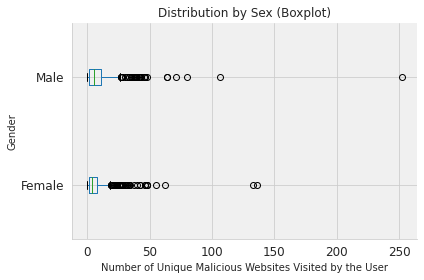

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")  # Set the plot style
plt.figure(figsize=(8, 6))

fin_dat['gender_lab_enc'] = pd.factorize(fin_dat['gender_lab'])[0] + 1
label_mapping = dict(zip(fin_dat['gender_lab_enc'], fin_dat['gender_lab']))

ax = fin_dat.boxplot(column='malicious_bool', by='gender_lab_enc', vert=False)

# Set x-axis ticks and labels
ticks = list(label_mapping.keys())
labels = list(label_mapping.values())
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

# Adjust tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a light gray background to the plot
plt.gca().set_facecolor('#f0f0f0')

# Remove right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel('Number of Unique Malicious Websites Visited by the User')
plt.ylabel('Gender')
plt.title('Distribution by Sex (Boxplot)')
plt.suptitle('')
plt.show()

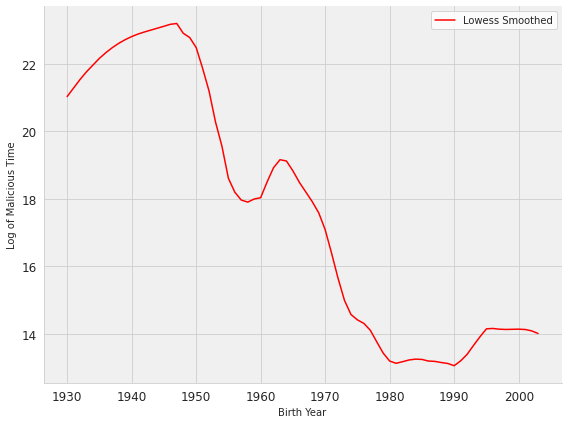

In [30]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

sns.set_style("whitegrid")  # Set the plot style
plt.figure(figsize=(8, 6))

lowess_model = lowess(fin_dat['malicious_time'], fin_dat['birthyr'], frac=0.3)

plt.plot(lowess_model[:, 0], lowess_model[:, 1], color='red', label='Lowess Smoothed')

# Adjust tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a light gray background to the plot
plt.gca().set_facecolor('#f0f0f0')

# Remove right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel('Birth Year')
plt.ylabel('Log of Malicious Time')
plt.legend()

plt.tight_layout()

plt.savefig('age_time_malicious.png', dpi=300)
plt.show()

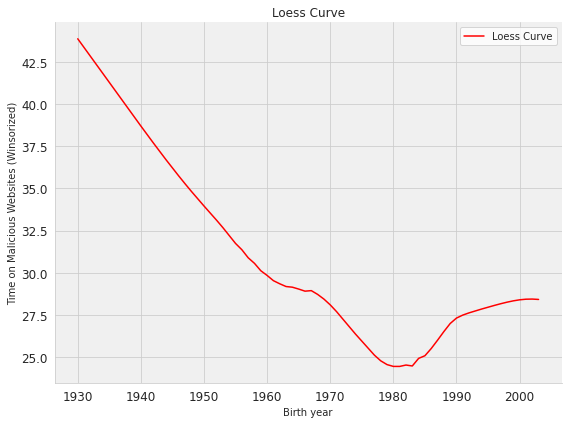

In [31]:
from scipy.stats.mstats import winsorize
winsorized_mal_time = winsorize(fin_dat['malicious_time'], limits=(0.0, 0.2))  # Adjust the limits as per your preference

lowess = sm.nonparametric.lowess(winsorized_mal_time, fin_dat['birthyr'], frac=0.5)  

sns.set_style("whitegrid")  # Set the plot style
plt.figure(figsize=(8, 6))

plt.plot(lowess[:, 0], lowess[:, 1], color='red', label='Loess Curve')

# Adjust tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a light gray background to the plot
plt.gca().set_facecolor('#f0f0f0')

# Remove right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.legend()
plt.xlabel('Birth year')
plt.ylabel('Time on Malicious Websites (Winsorized)')
plt.title('Loess Curve')

plt.tight_layout()

plt.savefig('age_time_malicious_winsorized.png', dpi=300)
plt.show()

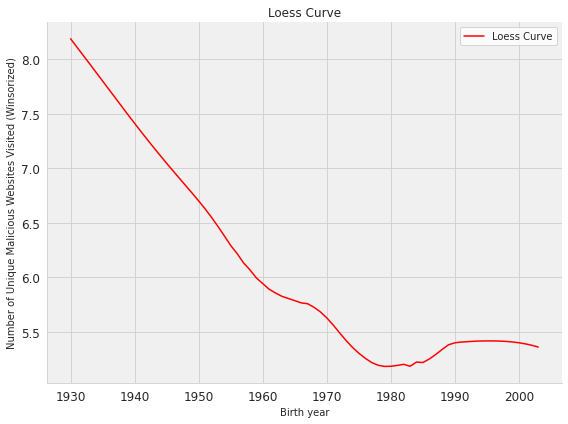

In [32]:
from scipy.stats.mstats import winsorize
winsorized_mal_bool = winsorize(fin_dat['malicious_bool'], limits=(0.0, 0.2))  # Adjust the limits as per your preference

lowess = sm.nonparametric.lowess(winsorized_mal_bool, fin_dat['birthyr'], frac=0.5)  

sns.set_style("whitegrid")  # Set the plot style
plt.figure(figsize=(8, 6))

plt.plot(lowess[:, 0], lowess[:, 1], color='red', label='Loess Curve')

# Adjust tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a light gray background to the plot
plt.gca().set_facecolor('#f0f0f0')

# Remove right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.legend()
plt.xlabel('Birth year')
plt.ylabel('Number of Unique Malicious Websites Visited (Winsorized)')
plt.title('Loess Curve')

plt.tight_layout()

plt.savefig('age_n_malicious_winsorized.png', dpi=300)
plt.show()